In [1]:
import os
import json
from pathlib import Path
current_directory = Path().resolve()
project_directory = current_directory.parent.parent
os.chdir(project_directory)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

file_name = "NH4_rate_3_3_rcts_ads_ads_ads.json"
file_path = project_directory / "resources" / file_name

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

for reaction_key, reaction_data in data.items():
    if "x" in reaction_data:
        reaction_data["x"] = np.array(reaction_data["x"])




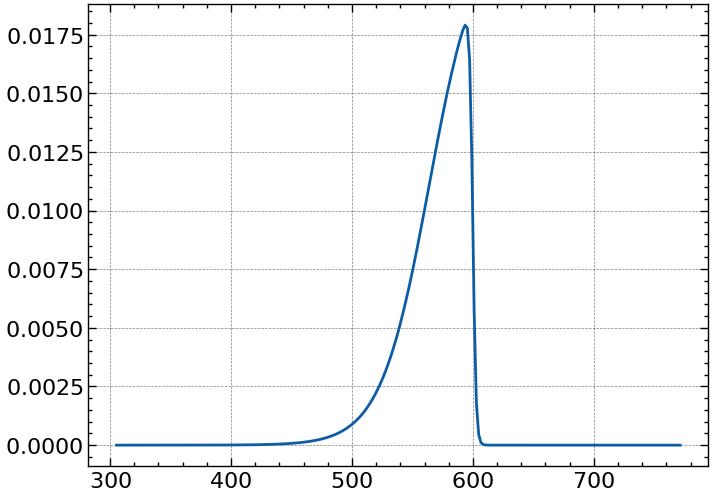

In [2]:
from src.core.curve_fitting import CurveFitting as cft

def parse_reaction(data, reaction_name):
    try:
        reaction_data = data[reaction_name]
        _x = (reaction_data["x"][0],  reaction_data["x"][-1])
        function_type = reaction_data["function"]
        coeffs = tuple([reaction_data["coeffs"][key] for key in cft._get_allowed_keys_for_type(function_type)])
        da_dT = cft.calculate_reaction((_x, function_type, coeffs))
        conversion = np.cumsum(da_dT)/np.cumsum(da_dT).max()
        x = np.linspace(_x[0], _x[1], 250)
        temperature = x + 273.15
    except KeyError as e:
        return None, None
    return temperature, conversion, da_dT
    
temperature, conversion, da_dT = parse_reaction(data, "reaction_1")
plt.plot(temperature, da_dT) if temperature is not None else None

In [3]:
from src.core.model_fit_calculation import CoatsRedfern
from src.core.app_settings import NUC_MODELS_TABLE, NUC_MODELS_LIST

ALPHA_MIN = 0.001 
ALPHA_MAX = 0.999
BETA = 3

temperature, conversion, da_dT = parse_reaction(data, "reaction_1")
Coats_Redfern = CoatsRedfern(ALPHA_MIN, ALPHA_MAX, 0.9)
cr_df = Coats_Redfern.calculate(temperature, conversion, BETA)

cr_df.head(5)

,Model,R2_score,Ea,A
30,G6,0.9753,332740.0,1.377e+29
10,D3,0.9749,142610.0,1.100e+10
29,G5,0.9749,247554.0,2.732e+21
28,G4,0.9743,162368.0,4.828e+13
1,A2/3,0.9736,119775.0,5.911e+09


<Axes: xlabel='reverse_temperature'>

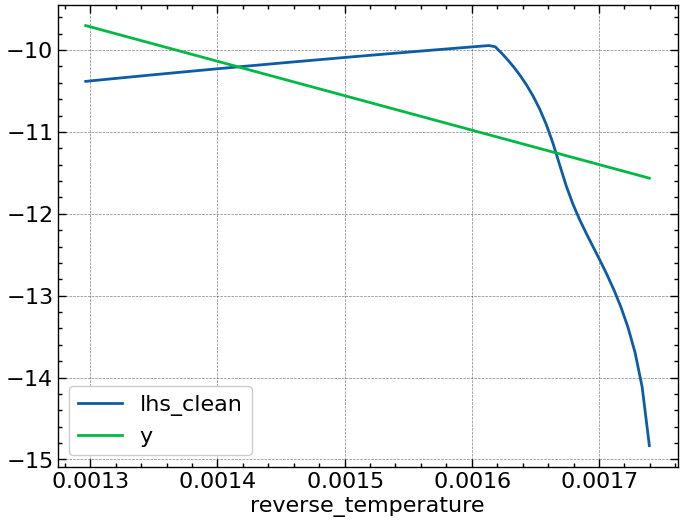

In [4]:
model_key = "B1"
model_func = NUC_MODELS_TABLE[model_key]["integral_form"]
g_a_val = model_func(1 - conversion)
lhs = Coats_Redfern.calculate_coats_redfern_lhs(g_a_val, temperature)
temperature_clean, lhs_clean = Coats_Redfern._filter_inf_data(lhs, temperature)
reverse_temperature = 1 / temperature_clean

_x = reverse_temperature
_y = lhs_clean
slope, intercept = np.polyfit(_x, _y, 1)
y = reverse_temperature * slope + intercept

plot_df = pd.DataFrame({"reverse_temperature": reverse_temperature, "lhs_clean": lhs_clean, "y": y})
plot_df.plot(x="reverse_temperature")

In [5]:
from src.core.model_fit_calculation import DirectDiff

direct_diff = DirectDiff(ALPHA_MIN, ALPHA_MAX, 0.9)
dd_df = direct_diff.calculate(temperature, pd.Series(conversion), BETA)
dd_df.head(10)

,Model,R2_score,Ea,A
10,D4,0.9985,199082.0,2.106e+16
30,G7,0.9978,202106.0,4.024e+17
8,D2,0.9970,193655.0,2.451e+16
36,R2,0.9967,99724.0,8.225e+07
29,G6,0.9966,-211931.0,1.161e-19
18,F1/3,0.9960,94747.0,3.170e+07
28,G5,0.9957,-103069.0,5.370e-10
31,G8,0.9936,209036.0,1.134e+18
9,D3,0.9936,209036.0,2.520e+17
37,R3,0.9886,104701.0,1.897e+08


<Axes: xlabel='temperature'>

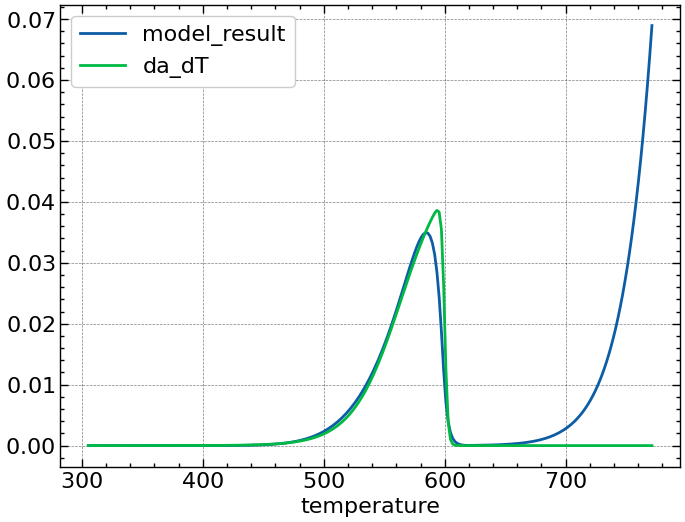

In [7]:
model_key = "G7"
dd_model = dd_df[dd_df["Model"] == model_key]
dd_result = (
    dd_model["A"].values.astype(float) / BETA 
    * np.exp(-dd_model["Ea"].values.astype(float) 
             / 8.314 / temperature
    ))

f_a = NUC_MODELS_TABLE[model_key]["differential_form"](1 - conversion)
model_result = dd_result * f_a
da_dT = pd.Series(conversion).diff()
da_dT[0] = 0

plot_df = pd.DataFrame({"temperature": temperature, "model_result": model_result, "da_dT": da_dT})
plot_df.plot(x="temperature")


In [1]:
import os
from pathlib import Path
current_directory = Path().resolve()
os.chdir(Path(current_directory).resolve().parent.parent)

import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import chardet

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

file_path = current_directory / "conversion_df.csv"

if not file_path.exists():
    raise Exception(f"File {file_path} does not exist.")

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

df = pd.read_csv(file_path, encoding=file_encoding, sep=',')

df.head()

,temperature,rate_3_diff_reaction_0_conversion,rate_3_diff_reaction_1_conversion,rate_3_diff_reaction_2_conversion,rate_3_diff_reaction_3_conversion,rate_5_diff_reaction_0_conversion,rate_5_diff_reaction_1_conversion,rate_5_diff_reaction_2_conversion,rate_5_diff_reaction_3_conversion,rate_10_diff_reaction_0_conversion,rate_10_diff_reaction_1_conversion,rate_10_diff_reaction_2_conversion,rate_10_diff_reaction_3_conversion
0,30.27800,9.827818e-08,9.972903e-14,1.085497e-95,4.368624e-31,1.631908e-08,1.548049e-12,9.211130e-119,4.843107e-36,2.327450e-08,7.123818e-12,6.808762e-155,2.411354e-26
1,31.23291,2.018687e-07,2.095083e-13,3.233271e-95,9.677860e-31,3.357247e-08,3.220325e-12,2.961691e-118,1.081627e-35,4.776307e-08,1.474954e-11,2.450654e-154,5.173075e-26
2,32.18783,3.111036e-07,3.302654e-13,7.470771e-95,1.613673e-30,5.182243e-08,5.035938e-12,7.472155e-118,1.820201e-35,7.349531e-08,2.290955e-11,7.056580e-154,8.346994e-26
3,33.14274,4.263148e-07,4.630829e-13,1.585870e-94,2.399608e-30,7.113127e-08,6.994890e-12,1.749843e-117,2.734337e-35,1.005601e-07,3.165242e-11,1.899695e-153,1.199494e-25
4,34.09766,5.478344e-07,6.091975e-13,3.248944e-94,3.352762e-30,9.156127e-08,9.129032e-12,3.969752e-117,3.864396e-35,1.290165e-07,4.101052e-11,5.003689e-153,1.615813e-25


In [6]:
current_directory.parent / "resources/"

WindowsPath('C:/IDE/repository/solid-state_kinetics/docs/resources')

Кинетику твердофазных реакций можно изучать с помощью термических аналитических методов путем измерения свойств образца при нагреве или при постоянной температуре. Если реакция связана с потерей массы, то масса отслеживается на протяжении реакции, и кинетика обычно изучается с помощью термогравиметрии (ТГА). Тепловой эффект (выделяющийся или поглощаемый) - это еще одно измеряемое свойство, которое используется для кинетической оценки с использованием дифференциальной сканирующей калориметрии (ДСК) или дифференциального термического анализа (ДТА). Данные о потере массы или потоке тепла преобразуются в нормализованную форму, называемую степенью превращения ($\alpha$). Степень превращения варьирует от 0 до 1 и является мерой прогресса реакции в зависимости от времени или температуры.

Для изотермического термогравиметрического анализа доля превращения в любой момент времени определяется следующим образом:

$$ \alpha = \frac{{m_0 - m_t}}{{m_0 - m_{\infty}}} \tag{1}$$

где:
$ m_0 $ - начальная масса образца,
 $ m_t $ - масса образца в момент времени $ t $, 
 $ m_{\infty} $ - конечная масса образца.

$$ Нахождение~производной~конверсии$$

Данные о производной конверсии обычно получают путем численного дифференцирования данных о конверсии, для чего может быть использован метод конечных разностей. Существует три формы конечных разностей: прямая, обратная и центральная разности. Для промежуточных точек данных производная конверсии обычно рассчитывается с помощью центральной разности. Прямые и обратные разности используются для оценки данных о производной конверсии начальной и конечной точек данных соответственно. Соответствующие формулы для расчета приведены ниже:

$$
\left( \frac{d\alpha}{dT} \right)_i = 
\begin{cases} 
\frac{\alpha_{i+1} - \alpha_i}{T_{i+1} - T_i} & \text{для начальной точки} \\
\frac{1}{2} \left( \frac{\alpha_{i} - \alpha_{i-1}}{T_i - T_{i-1}} + \frac{\alpha_{i+1} - \alpha_i}{T_{i+1} - T_i} \right) & \text{для промежуточных точек} \\
\frac{\alpha_i - \alpha_{i-1}}{T_i - T_{i-1}} & \text{для конечной точки}
\end{cases}
$$


$$ Прямой~дифференциальный~метод$$
Этот метод использует скорость нагрева, обычно линейную ($\beta$), для повышения температуры. Линейная программа нагрева следует формуле:

$$ T = T_0 + \beta t \tag{2}$$

где $T_0$ - начальная температура, $\beta$ - линейная скорость нагрева (К/мин), и $T$ - температура в момент времени $t$. 

Следующее соотношение можно определить для неизотермических экспериментов:

$$ \frac{{d\alpha}}{{dT}} = \frac{{d\alpha}}{{dt}} \cdot \frac{{dt}}{{dT}} \tag{3}$$

где $\frac{{d\alpha}}{{dT}}$ - неизотермическая скорость реакции; $\frac{{d\alpha}}{{dt}}$ - изотермическая скорость реакции, а $\frac{{dt}}{{dT}}$ - скорость нагрева ($\beta$). 

Дифференциальный закон скорости для реакции первого порядка может быть записан в виде:$$ Скорость~реакции~=~\frac{d[A]}{dt}=-k[A]\tag{4}$$ 
Здесь скорость реакции (изменение концентрации $[A]$ в единицу времени) пропорциональна концентрации реагента $[A]$. Отрицательный знак указывает на то, что концентрация $[A]$ с течением времени уменьшается.


Переформулировав уравнение (4), заменим концентрацию реагента $[A]$ на степень превращения $\alpha$: $$ Скорость~реакции~=~\frac{d\alpha}{dt} = k\left(1 - \alpha\right) \tag{5}$$

Обобщим уравнение (5), введя функцию $f(\alpha)$, которая отражает специфический характер реакции.$$\frac{d\alpha}{dt} = kf(\alpha)\tag{6}$$ 

Уравнение Аррениуса, которое описывает температурную зависимость константы скорости реакции выглядит следующим образом:$$k = A e^{-\frac{E_a}{RT}} \tag{7}$$
Путем подстановки уравнения Аррениуса (7) в обобщенный дифференциальный закон скорости (6) получаем:$$\frac{d\alpha}{dt} = A e^{-\frac{E_a}{RT}}f(\alpha) \tag{8}$$
Подставляя уравнение (8) в уравнение (3), получим дифференциальную форму неизотермического закона скорости:

$$ \frac{{d\alpha}}{{dT}} = \frac{A}{\beta}  e^{-\frac{{E_a}}{{RT}}}  f(\alpha) \tag{9}$$
Откуда: $$\ln\left(\frac{{da}}{{dT}}\cdot\frac{{1}}{{f(a)}}\right) = \ln \frac{{A}}{{\beta}} - \frac{{E_a}}{{RT}} \tag{10}$$

Построение графика левой части (включая модель $f(\alpha)$) относительно $\frac{1}{T}$ позволяет получить энергию активации ($E_a$) и предэкспоненциальный множитель ($A$) из наклона и пересечения с осью $y$ соответственно. Обычно выбирается модель, которая обеспечивает наилучшую линейную аппроксимацию.


In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.constants import R
from src.core.app_settings import NUC_MODELS_TABLE, NUC_MODELS_LIST

ALPHA_MIN = 0.001 # Минимальная конверсия
ALPHA_MAX = 0.999 # Максимальная конверсия
BETA = 3
conversion = df["rate_3_diff_reaction_0_conversion"]

temperature = df["temperature"] + 273.15

def calculate_direct_diff_lhs(da_dT, f_a_val):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.log(da_dT / f_a_val)
        result[~np.isfinite(result)] = np.inf  # Заменить NaN и inf на бесконечность
    return result

def calculate_direct_diff_params(slope, intercept, beta):
    Ea = -slope * R
    A = np.exp(intercept) * int(beta)
    return Ea, A

def process_model(temperature, conversion, model_key, beta):
    da_dT = conversion.diff()
    model_func = NUC_MODELS_TABLE[model_key]["differential_form"]
    f_a_val = model_func(1 - conversion)

    lhs = calculate_direct_diff_lhs(da_dT, f_a_val)

    reverse_temperature = 1 / temperature
    valid_mask = np.isfinite(lhs) & np.isfinite(reverse_temperature)

    if np.sum(valid_mask) < len(temperature) * 0.8:  # Если недостаточно данных для линейной регрессии
        return pd.DataFrame({
            'Model': [model_key],
            'R2_score': [np.nan],
            'Ea': [np.nan],
            'A': [np.nan],
        })

    slope, intercept, r_value, p_value, std_err = stats.linregress(reverse_temperature[valid_mask], lhs[valid_mask])
    Ea, A = calculate_direct_diff_params(slope, intercept, beta)

    return pd.DataFrame({
        'Model': [model_key],
        'R2_score': [r_value**2],
        'Ea': [Ea],
        'A': [A],
    })

def trim_conversion(temperature, conversion):
    valid_mask = (conversion >= ALPHA_MIN) & (conversion <= ALPHA_MAX)
    trimmed_conversion = conversion[valid_mask]
    trimmed_temperature = temperature[valid_mask]

    return trimmed_temperature, trimmed_conversion

def obtain_direct_diff_coeffs(temperature, conversion, beta):
    direct_diff = pd.DataFrame(columns=['Model', 'R2_score', 'Ea', 'A'])
    trimmed_temperature, trimmed_conversion = trim_conversion(temperature, conversion)
    for i, model in enumerate(NUC_MODELS_LIST):
        temp_df = process_model(trimmed_temperature, trimmed_conversion, NUC_MODELS_LIST[i], beta)
        direct_diff = pd.concat([direct_diff, temp_df], ignore_index=True)

    return direct_diff


direct_diff = obtain_direct_diff_coeffs(temperature, conversion, BETA)

df_sorted = direct_diff.sort_values(by='R2_score', ascending=False)

df_sorted['R2_score'] = df_sorted['R2_score'].round(4)
df_sorted['Ea'] = df_sorted['Ea'].round()
df_sorted['A'] = df_sorted['A'].apply(lambda x: f"{x:.3e}")

df_sorted

C:\Users\davjd\AppData\Local\Temp\ipykernel_26648\3559629049.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  direct_diff = pd.concat([direct_diff, temp_df], ignore_index=True)


,Model,R2_score,Ea,A
1,A2/3,0.9986,146113.0,1.203e+13
4,A3/4,0.9984,129144.0,2.635e+11
30,G6,0.9983,-210246.0,5.434e-21
20,F1/A1,0.9975,95205.0,1.201e+08
29,G5,0.9967,-108429.0,1.816e-11
3,A3/2,0.9947,61266.0,4.867e+04
0,A2,0.9902,44296.0,8.998e+02
12,D5,0.9887,223709.0,1.205e+20
6,A5/2,0.9836,34115.0,7.805e+01
32,G8,0.9808,172397.0,8.972e+14


In [ ]:
def calculate_coats_redfern_lhs(g_a_val, temperature):
        try:
            return np.log(g_a_val / (temperature**2))
        except ZeroDivisionError:
            return np.inf

def calculate_coats_redfern_params(slope, intercept, beta, temperature):
    Ea = -slope * R
    t_mean = temperature.mean()
    A = np.exp(intercept) / (1 - t_mean * R * 2 / Ea) * beta * Ea / R
    return Ea, A

def process_coats_redfern_model(conversion, temperature, model_func, model_name, beta):
    g_a_val = model_func(1 - conversion)
    lhs = calculate_coats_redfern_lhs(g_a_val, temperature)
    temperature_clean, lhs_clean = _filter_inf_data(lhs, temperature)
    reverse_temperature = 1 / temperature_clean
    try:
        slope, intercept, r_value, _, _ = stats.linregress(reverse_temperature, lhs_clean)
    except ValueError:
        return pd.DataFrame({
            "Model": [model_name],
            "R2_score": [None],
            "Ea": [None],
            "A": [None],
        })

    Ea, A = calculate_coats_redfern_params(slope, intercept, beta, temperature)

    return pd.DataFrame({
        "Model": [model_name],
        "R2_score": [r_value**2],
        "Ea": [Ea],
        "A": [A],
    })

def calculate_CR(temperature: pd.Series, conversion: pd.Series, beta: int) -> pd.DataFrame:
    result_list = []
    for model_key in NUC_MODELS_LIST:
        model_func = NUC_MODELS_TABLE[model_key]["integral_form"]
        temp_df = process_coats_redfern_model(conversion, temperature, model_func, model_key, beta)
        result_list.append(temp_df)

    if result_list:
        coats_redfern = pd.concat(result_list, ignore_index=True)
        coats_redfern["R2_score"] = coats_redfern["R2_score"].round(4)
        coats_redfern["Ea"] = coats_redfern["Ea"].round()
        coats_redfern["A"] = coats_redfern["A"].apply(lambda x: f"{x:.3e}")
        coats_redfern = coats_redfern.sort_values(by="R2_score", ascending=False)
    else:
        coats_redfern = pd.DataFrame(columns=["Model", "Equation", "R2_score", "Ea", "A"])

    return coats_redfern

def _filter_inf_data(lhs, temperature):
    mask = np.isfinite(lhs) & np.isfinite(temperature)
    return temperature[mask], lhs[mask]


calculate_CR(temperature, conversion, BETA)

c:\Users\davjd\AppData\Local\pypoetry\Cache\virtualenvs\solid-state-kinetics-FqwXzyQX-py3.12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\davjd\AppData\Local\pypoetry\Cache\virtualenvs\solid-state-kinetics-FqwXzyQX-py3.12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\davjd\AppData\Local\pypoetry\Cache\virtualenvs\solid-state-kinetics-FqwXzyQX-py3.12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\davjd\AppData\Local\pypoetry\Cache\virtualenvs\solid-state-kinetics-FqwXzyQX-py3.12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\davjd\AppData\Local

,Model,R2_score,Ea,A
30,G6,0.9855,-313731.0,-1.664e+28
29,G5,0.9851,-233303.0,-5.343e+20
28,G4,0.9845,-152875.0,-1.497e+13
1,A2/3,0.9838,-112661.0,-2.259e+09
4,A3/4,0.9834,-99256.0,-1.169e+08
20,F1/A1,0.9822,-72446.0,-2.914e+05
3,A3/2,0.9793,-45637.0,-6.070e+02
0,A2,0.9758,-32232.0,-2.381e+01
12,D5,0.9750,-193702.0,-5.671e+17
6,A5/2,0.9714,-24190.0,-3.060e+00


$$Метод~Фримена~и~Кэрролла$$

Взятие натурального логарифма от дифференциальной формы закона скорости неизотермической реакции (уравнение 9) даёт:

$$
\ln \frac{d\alpha}{dT} = \ln \frac{A}{\beta} - \frac{Ea}{RT} + \ln f(\alpha) \tag{11}
$$

Если взять приращения переменных в уравнении (11), получим:

$$
\Delta \ln \frac{d\alpha}{dT} = \Delta \ln f(\alpha) - \frac{Ea}{R}\,\Delta \frac{1}{T} \tag{12}
$$

Разделив обе части уравнения (12) на приращение обратной температуры, получим:

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \frac{1}{T}} = \frac{\Delta \ln f(\alpha)}{\Delta \frac{1}{T}} - \frac{Ea}{R} \tag{13}
$$

или, разделив уравнение (12) на $\Delta \ln f(\alpha)$:

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \ln f(\alpha)} = 1 - \frac{Ea}{R}\,\frac{\Delta \frac{1}{T}}{\Delta \ln f(\alpha)} \tag{14}
$$

Активационная энергия может быть получена путём построения графика левой части уравнения (13) против $\Delta \ln f(\alpha) / \Delta \frac{1}{T}$ (точка пересечения с осью ординат) или графика левой части уравнения (14) против $\Delta \frac{1}{T} / \Delta \ln f(\alpha)$ с нахождением угла наклона прямой.


In [4]:
def process_freeman_carr_model(conversion, temperature, model_func, model_name, beta, R, DEBUG=False):
    conversion_series = pd.Series(conversion)
    da_dT = conversion_series.diff().astype(float)
    epsilon = 1e-8
    da_dT = da_dT.replace(0, epsilon)
    ln_da_dT = np.log(da_dT.values)
    ln_f_a = np.log(model_func(conversion_series) + epsilon)
    m = len(temperature)
    x = []
    y = []
    for j in range(2, m-1):
        Δ_ln_da_dT = ln_da_dT[j] - ln_da_dT[j-1]
        Δ_1_T = 1/temperature[j+1] - 1/temperature[j]
        Δ_ln_f_a = ln_f_a[j+1] - ln_f_a[j]
        if np.isnan(Δ_ln_da_dT) or np.isnan(Δ_ln_f_a):
            continue
        if np.abs(Δ_1_T) > epsilon:
            x_val = Δ_ln_f_a / Δ_1_T
            y_val = Δ_ln_da_dT / Δ_1_T
            x.append(x_val)
            y.append(y_val)
        else:
            continue
    if len(x) < 2 or len(x) != len(y) or np.std(x) < epsilon:
        return pd.DataFrame({
            "Model": [model_name],
            "R2_score": [None],
            "Ea": [None],
            "A": [None],
        })
    x_arr = np.array(x)
    y_arr = np.array(y)
    slope, intercept, r_value, _, _ = stats.linregress(x_arr, y_arr)
    Ea = R * intercept
    temperature_array = np.array(temperature[1:])
    ln_A_over_beta = ln_da_dT[1:] + Ea/(R * temperature_array) - ln_f_a[1:]
    average_ln_A_over_beta = np.mean(ln_A_over_beta)
    A = beta * np.exp(average_ln_A_over_beta)
    return pd.DataFrame({
        "Model": [model_name],
        "R2_score": [r_value**2],
        "Ea": [Ea],
        "A": [A],
    })

def calculate_FC(temperature, conversion, beta, R, NUC_MODELS_LIST, NUC_MODELS_TABLE, DEBUG=False):
    result_list = []
    for model_key in NUC_MODELS_LIST:
        model_func = NUC_MODELS_TABLE[model_key]["differential_form"]
        temp_df = process_freeman_carr_model(conversion, temperature, model_func, model_key, beta, R, DEBUG=DEBUG)
        result_list.append(temp_df)
    if result_list:
        freeman_carr = pd.concat(result_list, ignore_index=True)
        freeman_carr["R2_score"] = freeman_carr["R2_score"].round(4)
        freeman_carr["Ea"] = freeman_carr["Ea"].round()
        freeman_carr["A"] = freeman_carr["A"].apply(lambda x: f"{x:.3e}" if pd.notnull(x) else x)
        freeman_carr = freeman_carr.sort_values(by="R2_score", ascending=False)
    else:
        freeman_carr = pd.DataFrame(columns=["Model", "R2_score", "Ea", "A"])
    return freeman_carr

calculate_FC(temperature, conversion, BETA, R, NUC_MODELS_LIST, NUC_MODELS_TABLE, DEBUG=False)


c:\Users\davjd\AppData\Local\pypoetry\Cache\virtualenvs\solid-state-kinetics-FqwXzyQX-py3.12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\davjd\AppData\Local\Temp\ipykernel_26648\1291005290.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  freeman_carr = pd.concat(result_list, ignore_index=True)


,Model,R2_score,Ea,A
20,F1/A1,0.8388,492571.0,3.809e+47
19,F1/3,0.8348,491142.0,1.819e+46
37,R2,0.8348,491142.0,2.421e+46
27,G3,0.8348,491142.0,1.138e+42
26,G2,0.8348,491142.0,2.665e+43
25,G1,0.8348,491142.0,5.549e+44
24,F3/4,0.8348,491151.0,2.868e+46
38,R3,0.8348,491145.0,2.867e+46
23,F3/2,0.8346,489255.0,4.453e+47
14,D7,0.8081,477873.0,2.011e+42
